In [1]:
import jax
import jax.numpy as jnp  # JAX NumPy
import optax  # Optimizers
import equinox as eqx  # Equinox

from flowMC.resource.model.common import MLP
from flowMC.resource.model.flowmatching.base import Solver, Path, CondOTScheduler, FlowMatchingModel
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt


In [2]:
solver = Solver(MLP([3,16,16,2], jax.random.PRNGKey(0), activation=jax.nn.swish))
path = Path(CondOTScheduler())
model = FlowMatchingModel(solver, path)

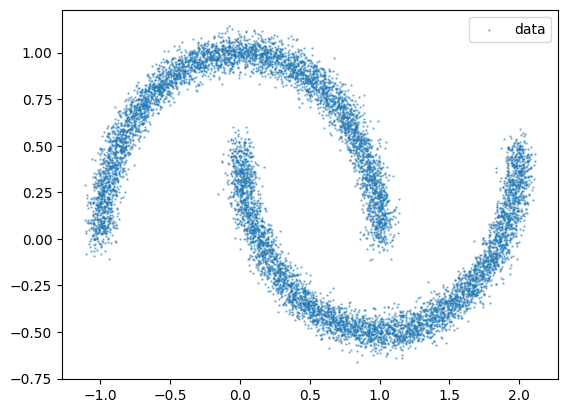

In [3]:
data = jnp.array(make_moons(n_samples=10000, noise=0.05)[0])

plt.scatter(data[:, 0], data[:, 1], s=0.5, alpha=0.5, label="data")
plt.legend()

In [4]:
# Optimization parameters
num_epochs = 100
batch_size = 10000
learning_rate = 0.001
momentum = 0.9
key = jax.random.PRNGKey(0)

key, subkey = jax.random.split(key)
x0 = jax.random.normal(subkey, (data.shape[0], 2))  # Initial points
key, subkey = jax.random.split(key)
t = jax.random.uniform(subkey, (data.shape[0], 1), minval=0.0, maxval=1.0)  # Random time points

optim = optax.adam(learning_rate)
state = optim.init(eqx.filter(model, eqx.is_array))
key, subkey = jax.random.split(key)
key, trained_model, state, loss = model.train(
    key, (x0, data, t), optim, state, num_epochs, batch_size, verbose=True
)

Training NF, current loss: 1.748:  10%|█         | 10/100 [00:00<00:01, 55.83it/s]

Compiling training step


Training NF, current loss: 1.748: 100%|██████████| 100/100 [00:00<00:00, 351.82it/s]


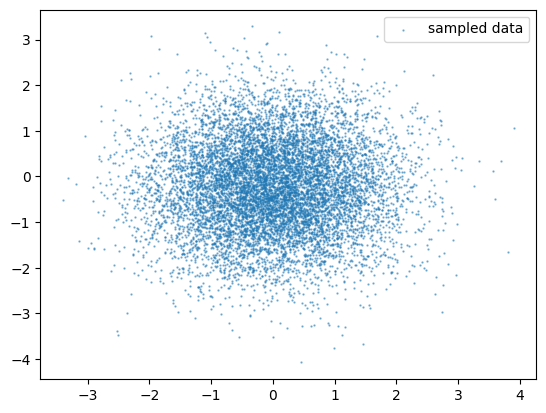

In [5]:
sampled_data = model.sample(key, 10000)
plt.scatter(sampled_data[:, 0], sampled_data[:, 1], s=0.5, alpha=0.5, label="sampled data")
plt.legend()
plt.show()

In [8]:
trained_model.solver.model.layers[0].weight == model.solver.model.layers[0].weight  # Check if weights are equal

Array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]], dtype=bool)

In [9]:
loss

Array([1.7479613, 1.7479613, 1.7479613, 1.7479613, 1.7479613, 1.7479613,
       1.7479613, 1.7479613, 1.7479613, 1.7479613, 1.7479613, 1.7479613,
       1.7479613, 1.7479613, 1.7479613, 1.7479613, 1.7479613, 1.7479613,
       1.7479613, 1.7479613, 1.7479613, 1.7479613, 1.7479613, 1.7479613,
       1.7479613, 1.7479613, 1.7479613, 1.7479613, 1.7479613, 1.7479613,
       1.7479613, 1.7479613, 1.7479613, 1.7479613, 1.7479613, 1.7479613,
       1.7479613, 1.7479613, 1.7479613, 1.7479613, 1.7479613, 1.7479613,
       1.7479613, 1.7479613, 1.7479613, 1.7479613, 1.7479613, 1.7479613,
       1.7479613, 1.7479613, 1.7479613, 1.7479613, 1.7479613, 1.7479613,
       1.7479613, 1.7479613, 1.7479613, 1.7479613, 1.7479613, 1.7479613,
       1.7479613, 1.7479613, 1.7479613, 1.7479613, 1.7479613, 1.7479613,
       1.7479613, 1.7479613, 1.7479613, 1.7479613, 1.7479613, 1.7479613,
       1.7479613, 1.7479613, 1.7479613, 1.7479613, 1.7479613, 1.7479613,
       1.7479613, 1.7479613, 1.7479613, 1.7479613, 